In [1]:
# Downgrade NumPy to fix Box2D compatibility issue
# NumPy 2.x has breaking changes that Box2D doesn't support yet
# !pip install 'numpy<2.0'


In [3]:
!pip install -U "gymnasium[box2d]"

In [1]:
import gymnasium as gym
env = gym.make('CarRacing-v2')

/home/ganeev/anaconda3/envs/WorldModels/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


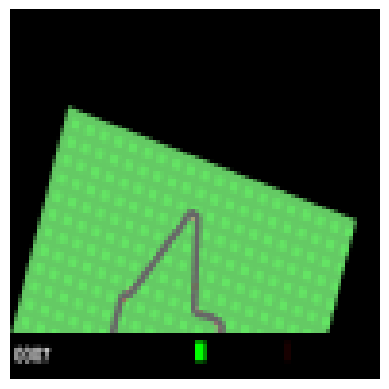

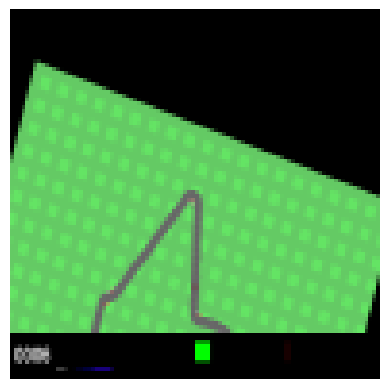

In [11]:
import matplotlib.pyplot as plt

noi = 2

def display(image):
    """Display a numpy array image using matplotlib"""
    plt.imshow(image)
    plt.axis('off')
    plt.show()

observation, info = env.reset(seed=42)
for _ in range(100):
    # this is where you would insert your policy
    action = env.action_space.sample()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action)
    # Types: <class 'numpy.ndarray'> <class 'float'> <class 'bool'> <class 'bool'> <class 'dict'>

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

    if noi > 0:
        display(observation)
        noi -= 1

env.close()

In [5]:
import cv2


def preprocess(frame, output_size=(84,84)):

    """Convert an RGB frame to a resized grayscale image.

    - Converts from RGB to grayscale using OpenCV.
    - Resizes to the given output_size using area interpolation.

    Args:
        frame (np.ndarray): RGB image of shape (H, W, 3), typically dtype uint8.
        output_size (tuple[int, int]): (width, height) of the output image. Defaults to (84, 84).

    Returns:
        np.ndarray: 2D grayscale image of shape (output_size[1], output_size[0]) with the same dtype as input.
    """

    gray=cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    resized=cv2.resize(gray, output_size, interpolation=cv2.INTER_AREA)
    return resized


In [ ]:
# import gymnasium as gym
# env = gym.make('CarRacing-v2')
# env.reset(seed=42)

# action = env.action_space.sample()
# obversation =env.step(action)
# print(preprocess(observation))
# env.close()

[[175 175 175 ... 160 160 160]
 [175 175 175 ... 160 160 160]
 [175 175 175 ... 160 160 160]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [14]:
import numpy as np
from collections import deque

# Create once and reuse across steps
frame_stack = deque(maxlen=4)

def stack_frames(frame, stack_size=4, output_size=(84, 84), init=False):
    """
    Preprocess and stack the last `stack_size` frames.
    
    Args:
        frame (np.ndarray): Current RGB frame (H, W, 3).
        stack_size (int): Number of frames to stack (channels-first).
        output_size (tuple[int, int]): (W, H) for preprocess.
        init (bool): If True, fills the stack with the current frame.

    Returns:
        np.ndarray: Stacked frames of shape (stack_size, H, W), dtype=uint8.
    """
    global frame_stack
    f = preprocess(frame, output_size=output_size)

    if init or len(frame_stack) == 0:
        frame_stack.clear()
        for _ in range(stack_size):
            frame_stack.append(f)
    else:
        frame_stack.append(f)

    return np.stack(frame_stack, axis=0)

# Example:
obs, info = env.reset(seed=42)
state = stack_frames(obs, init=True)          # (4, 84, 84)
print(state.shape)
obs, r, terminated, truncated, info = env.step(env.action_space.sample())
next_state = stack_frames(obs)                # (4, 84, 84)

(4, 84, 84)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

class DQNCNN(nn.Module):
    """
    CNN for DQN-style value estimation.
    Expects input of shape (B, in_channels, 84, 84), values in [0,1] float32.
    """
    def __init__(self, in_channels=4, n_actions=6):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, n_actions)

        # He init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                nn.init.constant_(m.bias, 0.0)
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        # x: (B, C, 84, 84), float32 in [0,1]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # (B, n_actions)


def dqn_loss(q_net, target_net, batch, gamma=0.99, double_dqn=True):
    """
    Huber (SmoothL1) loss for (S, A, R, S_next, done) batch.

    batch = {
        "s": Tensor (B, C, 84, 84) float32 in [0,1],
        "a": LongTensor (B,),
        "r": Tensor (B,),
        "s2": Tensor (B, C, 84, 84),
        "d": Tensor (B,) in {0,1}  // 1 if done
    }
    """
    s, a, r, s2, d = batch["s"], batch["a"], batch["r"], batch["s2"], batch["d"]

    # Q(s, a)
    q_pred = q_net(s).gather(1, a.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        if double_dqn:
            next_actions = q_net(s2).argmax(dim=1)               # a* = argmax_a Q(s', a)
            q_next = target_net(s2).gather(1, next_actions.unsqueeze(1)).squeeze(1)
        else:
            q_next = target_net(s2).max(dim=1).values

        target = r + gamma * (1.0 - d) * q_next

    return F.smooth_l1_loss(q_pred, target)


def train_step(q_net, target_net, optimizer, batch, gamma=0.99, grad_clip=10.0, double_dqn=True):
    """
    One optimization step. Returns scalar loss value.
    """
    optimizer.zero_grad(set_to_none=True)
    loss = dqn_loss(q_net, target_net, batch, gamma=gamma, double_dqn=double_dqn)
    loss.backward()
    nn.utils.clip_grad_norm_(q_net.parameters(), grad_clip)
    optimizer.step()
    return float(loss.item())


# Example wiring:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# n_actions = env.action_space.n  # must be discrete
# q_net = DQNCNN(in_channels=4, n_actions=n_actions).to(device)
# target_net = DQNCNN(in_channels=4, n_actions=n_actions).to(device)
# target_net.load_state_dict(q_net.state_dict())
# optimizer = optim.Adam(q_net.parameters(), lr=1e-4)

# To build a batch from numpy states (uint8, shape (B,4,84,84)):
# s  = torch.from_numpy(S).float().div_(255.0).to(device)
# s2 = torch.from_numpy(S_next).float().div_(255.0).to(device)
# a  = torch.from_numpy(A).long().to(device)
# r  = torch.from_numpy(R).float().to(device)
# d  = torch.from_numpy(D).float().to(device)
# batch = {"s": s, "a": a, "r": r, "s2": s2, "d": d}
# loss = train_step(q_net, target_net, optimizer, batch)

In [ ]:
# Initialize:
#   env = AtariEnv(game, frameskip, repeat_action)
#   Q = CNN(params)                  // online network
#   Q_target = clone(Q)              // target network
#   ReplayBuffer B with capacity N
#   optimizer = Adam(Q.parameters, lr)
#   epsilon = epsilon_start
#   gamma = discount_factor
#   update_target_every = K steps
#   batch_size = M

# Preprocessing:
#   function preprocess(frame):
#     gray = to_grayscale(frame)
#     resized = resize(gray, 84x84)
#     return resized

#   function stack_frames(f_t):
#     // maintain last 4 frames for state
#     update deque with preprocess(f_t)
#     return concat(last 4 frames)   // shape (4, 84, 84)

# Training loop:
#   state = stack_frames(env.reset())
#   total_steps = 0

#   for episode in range(num_episodes):
#     done = false
#     while not done:
#       // ε-greedy action selection
#       with prob epsilon:
#         action = random_action()
#       else:
#         action = argmax_a Q(state)[a]

#       // step environment
#       next_frame, reward, terminated, truncated, info = env.step(action)
#       next_state = stack_frames(next_frame)
#       done = terminated or truncated

#       // store transition
#       B.add((state, action, reward, next_state, done))

#       state = next_state
#       total_steps += 1

#       // anneal exploration
#       epsilon = max(epsilon_min, linear_decay(epsilon_start, epsilon_min, total_steps, decay_steps))

#       // learn after warmup
#       if B.size >= warmup and total_steps % learn_every == 0:
#         // sample mini-batch
#         batch = B.sample(batch_size)  // uniformly or prioritized
#         (S, A, R, S_next, D) = batch

#         // compute target Q-values using target network
#         with no_grad:
#           // vanilla DQN:
#           target_q_next = max_a Q_target(S_next)[a]
#           // Double DQN (preferred):
#           a_max = argmax_a Q(S_next)[a]
#           target_q_next = Q_target(S_next)[a_max]

#           y = R + gamma * (1 - D) * target_q_next

#         // compute current Q for taken actions
#         q = Q(S)[A]

#         // loss: Huber(MSE)
#         loss = huber(q, y)

#         // gradient step
#         optimizer.zero_grad()
#         loss.backward()
#         clip_grad_norm(Q.parameters, max_norm)
#         optimizer.step()

#       // periodically update target network
#       if total_steps % update_target_every == 0:
#         Q_target = clone(Q)         // hard update
#         // or soft: Q_target = τ*Q + (1-τ)*Q_target

# Evaluation (optional):
#   disable exploration (epsilon = eval_epsilon)
#   run episodes, report average reward, frames, etc.